# Classify Sentinel 2a L2C data into Land Cover classes using random forest technique

Using an area clipped to the Isle of Wight and a training dataset.  The bands used are those available at the 10m resolution:
* Bands 2, 3, 4, 8

The sci-kit learn random forest classifier was used.

Based upon:
https://github.com/ceholden/open-geo-tutorial/blob/master/Python/chapters/chapter_5_classification.ipynb

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

The training data was created by digitizing polygons over observed land cover types and converting the dataset to raster.

The classes used are:
* 01 - water
* 02 - earth
* 03 - vegetation
* 04 - urban

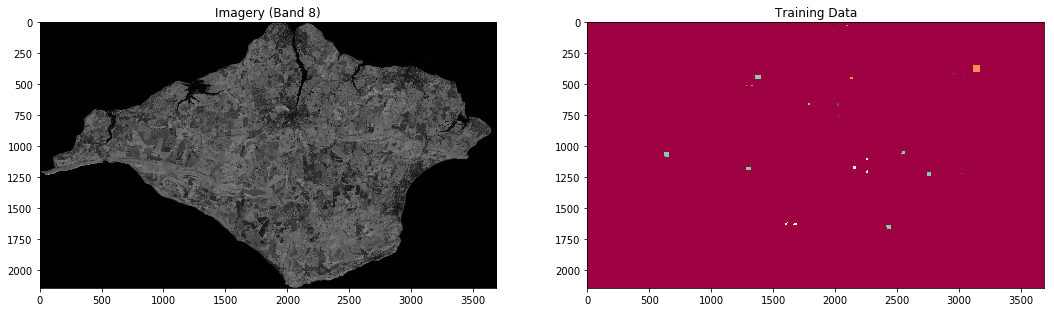

In [2]:
imgpath = "data/s2a_l2a_iow_clipped.tif"
trainingpath = "data/training_data_01.tif"

# imagery to be classified
src = rasterio.open(imgpath)
fullimg = src.read()
# transpose so that bands are last
img = np.transpose(fullimg, (1,2,0))

# training data
timg = rasterio.open(trainingpath)
tarray = timg.read(1).astype(np.uint8)


# display the data
plt.subplots(figsize=(18, 18))

plt.subplot(121)
plt.imshow(img[:, :, 3], cmap=plt.cm.Greys_r)
plt.title("Imagery (Band 8)")

plt.subplot(122)
plt.imshow(tarray, cmap=plt.cm.Spectral)
plt.title("Training Data")

plt.show()

This function trains and classifies the image using random forest method.

In [3]:
def rfclassify(imgpath, trainingpath, outpath):
    """
    Classify multiband image using random forest method
    Parameters
    ----------
    imgpath : string
        Path to the image to be classified
    trainingpath : string
        Path to the raster training data
    outpath : string
        Path to the classified image to output
    """

    with rasterio.open(imgpath) as src:
        fullimg = src.read()
        img = np.transpose(fullimg, (1,2,0))
        
        with rasterio.open(trainingpath) as timg:
            tarray = timg.read(1).astype(np.uint8)

            # report number of non-zero entries 
            # i.e. number of training data samples
            n_samples = (tarray > 0).sum()
            print(f"There are {n_samples} samples")

            # report classification labels
            labels = np.unique(tarray[tarray > 0])
            print(f"Training data includes {labels.size} classes: {labels}")

            # create an "X" matrix containing features and a "y" array 
            # containing labels
            # these will have n_samples rows
            X = img[tarray > 0, :]
            y = tarray[tarray > 0]

            print(f"X matrix is sized: {X.shape}")
            print(f"y array is sized: {y.shape}")

            # initialize model with 500 trees
            rf = RandomForestClassifier(n_estimators=500, oob_score=True)

            # fit model to training data
            rf = rf.fit(X, y)

            print(f"OOB prediction of accuracy is: {rf.oob_score_ * 100}")

            #bands = [1, 2, 3, 4,]
            bands = []
            for b in range(img.shape[2]):
                bands.append(b+1)

            print (f"bands {bands}")

            # report band importances
            for b, imp in zip(bands, rf.feature_importances_):
                print(f"Band {b} importance: {imp}")

            # setup a dataframe
            df = pd.DataFrame()
            df["truth"] = y
            df["predict"] = rf.predict(X)

            # cross-tabulate predictions
            print(pd.crosstab(df["truth"], df["predict"], margins=True))

            # take full image, ignore the Fmask band, and reshape 
            # into long 2d array (nrow * ncol, nband) for classification
            new_shape = (img.shape[0] * img.shape[1], img.shape[2])

            img_as_array = img[:, :, :4].reshape(new_shape)
            print(f"Reshaped from {img.shape} to {img_as_array.shape}")
            
            print("Predicting...")
            # Predict for each pixel
            class_prediction = rf.predict(img_as_array)
            print("Prediction complete.  Writing results...")

            # Reshape the classification map
            class_prediction = class_prediction.reshape(img[:, :, 0].shape)

            # get the profile from the training data to use for the output
            profile = timg.profile
            profile.update(
                dtype=rasterio.int16,
                count=1,
                compress='lzw')

            with rasterio.open(outpath, 'w', **profile) as dst:
                dst.write(class_prediction.astype(rasterio.int16), 1)
            print("Results written.")
            

Run the classification - this takes a while

In [4]:
outpath = "data/rf_classified.tif"

rfclassify(imgpath, trainingpath, outpath)

There are 13453 samples
Training data includes 4 classes: [1 2 3 4]
X matrix is sized: (13453, 4)
y array is sized: (13453,)
OOB prediction of accuracy is: 99.89593399241805
bands [1, 2, 3, 4]
Band 1 importance: 0.2743025863217929
Band 2 importance: 0.03650594859810117
Band 3 importance: 0.20078683995788196
Band 4 importance: 0.48840462512222377
predict     1     2     3    4    All
truth                                
1        3909     0     0    0   3909
2           0  1618     0    0   1618
3           0     0  7140    0   7140
4           0     0     0  786    786
All      3909  1618  7140  786  13453
Reshaped from (2143, 3686, 4) to (7899098, 4)
Predicting...
Prediction complete.  Writing results...
Results written.


C:\ProgramData\Anaconda3\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Show the results

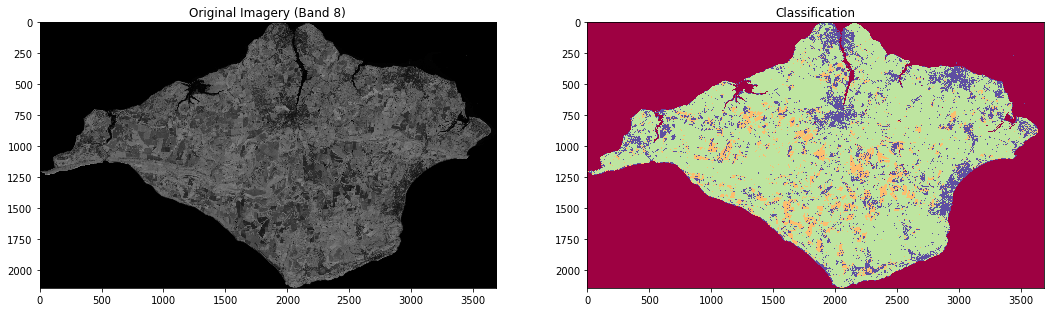

In [5]:
# display the data
with rasterio.open(outpath) as cimg:
    carray = cimg.read(1)

plt.subplots(figsize=(18, 18))

plt.subplot(121)
plt.imshow(img[:, :, 3], cmap=plt.cm.Greys_r)
plt.title('Original Imagery (Band 8)')

plt.subplot(122)
plt.imshow(carray, cmap=plt.cm.Spectral)
plt.title('Classification')

plt.show()